In [177]:
# For neural net
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# General
import numpy as np
import random
import math
from prettytable import PrettyTable


# For text
import re
import string

In [29]:
def create_joke_data(jokes, block_size, words):
    """
    Takes words list and breaks into training samples based on the desired model-type. For example,
    a bigram model where n=2 or a trigram model where n=3. 
    Returns xs and ys (inputs and labels).
    """
    # Init dicts
    itow = {i+1 : w for i, w in enumerate(sorted(words))}
    itow[0] = '.'
    wtoi = {w : i for i, w in itow.items()}
    n = block_size + 1

    # Create samples
    X, Y = [], []
    for j in jokes:
        context = [0] * block_size
        word_bag = j.split(' ') + ['.']  ##add special end characters
        word_bag = [w for w in word_bag if w != ""] ##remove any blank strings that get created
        for w in word_bag:
            ix = wtoi[w]
            X.append(context)
            Y.append(ix)
            # print([itow[c] for c in context], [itow[ix]])

            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
        
    n_samples = X.shape[0]
    print(f"{ n_samples = }")

    
    return X, Y


In [30]:

def split_samples(inputs, labels, frac=0.8, seed=123):
    "Split xs and ys (inputs and labels) into train and test sets"
    
    assert len(inputs)==len(labels), f"{len(inputs) = } which does not match {len(labels) = }"
    # generate a list of indices to exclude. Turn in into a set for O(1) lookup time
    random.seed(seed)
    indx = list(set(random.sample(list(range(len(inputs))), int(frac*len(inputs)))))

    x_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    x_mask[indx] = True

    y_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    y_mask[indx] = True

    train_x = inputs[x_mask]
    train_y = labels[y_mask]

    test_x = inputs[~x_mask]
    test_y = labels[~y_mask]

    return train_x, train_y, test_x, test_y

In [227]:
class OneLinerMLP:

    def __init__(self, block_size, words):
        """
        An instance of an MLP where 'block_size' defines the number of characters used 
        to predict the next character (the block size or context).
        """
        self.n_inputs = block_size ##the number of inputs (ie, excluding the label)

        # Init dicts
        self.itow = {i+1 : w for i, w in enumerate(sorted(words))}
        self.itow[0] = '.'
        self.wtoi = {w : i for i, w in itow.items()}

        self.n_outputs = int(len(self.itow))
        
         
    def initialize_weights(self,
                           embedding_dimensions=2,
                           hidden_layer_neurons=100, 
                           generator=None):
        "Randomly initialize the model's weights."
        self.hl_neurons = hidden_layer_neurons
        self.emb_dim = embedding_dimensions

        # INITALIZE NETWORK WEIGHTS
        n_inputs = self.n_inputs          ##number of inputs per sample (the block size)
        words = self.n_outputs            ##number of words in vocab
        emb_dim = embedding_dimensions    ##dimensions of embedding space
        hl_neurons = hidden_layer_neurons ##number of neurons in hidden layer


        self.C = torch.randn((words, emb_dim), generator=generator, requires_grad=True)

        # self.W1 = torch.randn((emb_dim*n_inputs, hl_neurons), generator=generator, requires_grad=True)
        self.W1 = self._xavier_init(emb_dim*n_inputs, hl_neurons, generator, requires_grad=True)
        self.b1 = torch.zeros(hl_neurons, requires_grad=True)

        # self.W2 = torch.randn((hl_neurons, words), generator=generator, requires_grad=True)
        self.W2 = self._xavier_init(hl_neurons, words, generator, requires_grad=True)
        self.b2 = torch.zeros(words, requires_grad=True)

        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad=True
        print(f"Model params = { sum(p.nelement() for p in self.parameters) }")

    def _xavier_init(self, n_inputs, n_neurons, generator=None, requires_grad=False):
        """My implementation of xavier-normal weight initialization for tanh layers"""
        with torch.no_grad():
            lower, upper = -(1.0 / math.sqrt(n_inputs)), (1.0 / math.sqrt(n_inputs))
            W = lower + torch.rand((n_inputs, n_neurons), generator=generator) * (upper - lower)
        W.requires_grad = requires_grad
        return W


    def forward_pass(self, xs, ys=None, regularization=0):
        "Perform a forward pass of the inputs (xs) through the network. If ys are provided, loss will be evaluated."
        # forward pass
        n_samples = xs.shape[0]
        n_inputs = self.n_inputs
        hl_neurons = self.hl_neurons
        emb_dim = self.emb_dim

        parameters = self.parameters

        assert n_inputs == xs.shape[1], f"n_inputs ({n_inputs}) does not match the xs.shape[1]"

        # Forward pass
        emb = self.C[xs]
        h = torch.tanh( emb.view(-1, n_inputs*emb_dim) @ self.W1 + self.b1 )   
        logits = h @ self.W2 + self.b2
        # predicted probabilities
        probs = F.softmax(logits, dim=1)

        # loss
        loss = None
        if ys is not None: #eval loss
            loss = F.cross_entropy(logits, ys)
            if regularization > 0.0:       
                for p in self.parameters:
                    loss += regularization*(p**2).mean()
            self.loss = loss
        
        return probs, loss
                

    def backprop_update(self, lr=0.1):
        "Gradient descent - backpropogate the network and apply a fraction of the gradients to the current weights."
        # backward pass
        for p in self.parameters:
            p.grad = None ##zero the gradient

        self.loss.backward() ##backprop

        # update params
        for p in self.parameters:
            p.data += -lr * p.grad ##learning rate


    def generate_jokes(self, n_words, start_words: str = None, min_length=0):
        """
        Generates n_words word examples by passing n-1 random characters into the model, performing a forward pass,
        and probabilistically choosing a character using the model's predicted probability distribution.
        Pass n-2 start_chrs to specify the starting characters of the word generation process (first character is always '.').
        Specify a minimum word length min_length to generate words at least that long.
        """
        itow = self.itow
        wtoi = self.wtoi
        n_inputs = self.n_inputs
        out_jokes = []

        for _ in range(n_words):
            joke = '.'
            context = [0] * n_inputs
            if start_words is not None:
                assert len(start_words.split()) <= n_inputs, f"Number of start words ({len(start_words.split())}) should be {n_inputs} or less."
                for w in start_words.split():
                    assert w in wtoi, f"Start word '{w}' cannot be used since it is not in the list of training words."
                    joke += " " + w.lower()
                    context[1:] + [wtoi[w.lower()]]

            while True:
                # forward pass
                probs, loss = self.forward_pass(
                    torch.tensor([context]) #.reshape(1, n_inputs)
                    )
                # Get word
                word_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
                # determine how to proceed
                if (word_ix==0) & (len(joke.split())-1 <= min_length): ##if the ix is 0 but the joke is too short, resample (-1 due to starting .)
                    pass
                elif (word_ix==0) & (len(joke.split())-1 > min_length): ##if the ix is 0 and joke is long enough, end joke and break joke creation
                    joke += " ." #itow[word_ix]
                    break
                else:                                   ##otherwise, add to the joke and shift the context for the next forward pass
                    joke += " " + itow[word_ix]
                    ## Shift words to predict the next one
                    context = context[1:] + [word_ix] ##shift and append  
            out_jokes.append(joke)    
        
        return out_jokes

# Data

In [228]:
# Read in text file - one joke per line
with open('jokes.txt') as f:
    jokes = f.read().splitlines()

# Create list of all words used in the jokes
words = set(' '.join([j for j in jokes]).split(' '))
words = [w for w in words if w != ""] ##remove empty string

print(f"{len(words) = }")

len(words) = 2378


In [220]:
# Mappings from integer to word
itow = {i+1 : w for i, w in enumerate(sorted(words))}
itow[0] = '.'
wtoi = {w : i for i, w in itow.items()}
len(itow)

2379

# Training

In [229]:
N = 3 ## Number of words used to predict the next word

# Create dataset based on N and split into training and development sets
X, Y = create_joke_data(jokes, block_size=N, words=words)
Xtr, Ytr, Xdev, Ydev = split_samples(X, Y, 0.8, seed=123)


 n_samples = 11266


In [230]:
# Initialize the joke model based on N and provide with list of words in data. Initialize weights based on desired model structure
g = torch.Generator().manual_seed(123)

model = OneLinerMLP(block_size=N, words=words)
model.initialize_weights(embedding_dimensions=10,
                         hidden_layer_neurons=100, 
                         generator=g)


# Initialzie lists to store metrics
losses, val_losses = [],[]

Model params = 267169


In [238]:
# TRAIN
steps = 1000
batch_size = None


print("losses:")
for k in range(steps):

    # minibatching
    if batch_size is not None:
        batch_ix = torch.randint(0, Xtr.shape[0], (batch_size, )) ##n_samples randints between 0 and length of data
    else:
        batch_ix=range(0, Xtr.shape[0]) ##all data included

    # forward pass
    probs, loss = model.forward_pass(Xtr[batch_ix], Ytr[batch_ix])

    # backward pass 
    lr = 1 #lrs[k]
    model.backprop_update(lr=lr)

    # validation eval
    with torch.no_grad():
        _, val_loss = model.forward_pass(Xdev, Ydev)

    # log updates & track stats
    if (k in range(0, steps, int(steps*0.10))) or (k==steps-1):
        print(f"Step {k}:", end=" ")
        print(f"Train - {round(loss.item(), 5)}", end=" ")
        print(f"Dev - {round(val_loss.item(), 5)}")
    

    losses.append(loss.item())
    val_losses.append(val_loss.item())
    # lr_losses.append(loss.item())

losses:
Step 0: Train - 5.35439 Dev - 5.90773
Step 100: Train - 5.03756 Dev - 5.88353
Step 200: Train - 4.73699 Dev - 5.88878
Step 300: Train - 4.45304 Dev - 5.91438
Step 400: Train - 4.1866 Dev - 5.95417
Step 500: Train - 3.93652 Dev - 6.00392
Step 600: Train - 3.70149 Dev - 6.06125
Step 700: Train - 3.48031 Dev - 6.12491
Step 800: Train - 3.27181 Dev - 6.19427
Step 900: Train - 3.0752 Dev - 6.26901
Step 999: Train - 2.89183 Dev - 6.34777


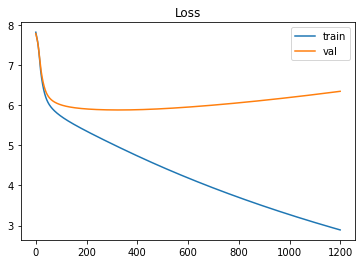

In [239]:
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.title("Loss")
plt.show()

In [240]:
model.generate_jokes(3)

['. i next to fell is but in a job in soar when like look time steal you had be drink .',
 '. what do you call stop you are the windshield of cheerleader .',
 '. did where an your nearby them .']